# step 52. supporting GPU

### cupy 설치 및 사용
* gpu를 이용해 모든 계산 수행
* numpy와 API가 거의 같음

In [ ]:
!pip install cupy

In [ ]:
import cupy as cp

x = cp.arange(6).reshape(2,3)
print(x)

y = x.sum(axis = 1)
print(y)

In [ ]:
import numpy as np

n = np.array([1,2,3])
c = cp.asarray(n)
assert type(c) == cp.ndarray

c = cp.array([1,2,3])
n = cp.asnumpy(c)
assert type(n) == np.ndarray

![](https://github.com/changdaeoh/DeepLearning-from-scratch/blob/main/images/52_note1.png?raw=true)

In [ ]:
# x가 numpy 배열인경우
x = np.array([1,2,3])
xp = cp.get_array_module(x)    
assert xp == np

# x가 cupy 배열인경우
x = cp.array([1,2,3])
xp = cp.get_array_module(x)
assert xp == cp

`cp.get_array_module(x)`
: input받은 배열이 속하는 모듈을 알아서 판단하여 반환한다.(np or cp) 

variable 클래스를 아래와 같이 수정한다.
* input 데이터 type으로 numpy array외에 cupy array도 지원한다.
* 흐르는 데이터로부터 알아서 적합한 모듈(np, cp)을 찾아 대응 함수를 적용시키도록 메서드들을 수정
* 데이터를 cpu <-> gpu 전송 가능하게하는 메서드를 추가u 전송 가능하게하는 메서드를 추가

모든 np. 로 시작하는 코드를 xp로 수정 (데이터로부터 적절한 모듈을 선택하도록)

In [ ]:
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP


max_epoch = 5
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# GPU mode
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()

for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

# step 53. load & save

In [3]:
import os 
os.getcwd()

'C:\\Users\\user\\study\\DLfromScratch3'

In [8]:
# save, savez, load function
import numpy as np

x = np.array([1,2,3])
np.save('test.npy', x)

y = np.load('test.npy')
print(y)

x1 = np.array([1,2,3])
x2 = np.array([4,5,6])
np.savez('test.npz', x1 = x1, x2 = x2) # 키워드 지정

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1); print(x2)

x1 = np.array([1,2,3])
x2 = np.array([4,5,6])
data = {'x1':x1, 'x2':x2}
np.savez('test2.npz', **data) 

arrays = np.load('test2.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1); print(x2)

[1 2 3]
[1 2 3]
[4 5 6]
[1 2 3]
[4 5 6]


In [ ]:
# layer 클래스에 추가
def _flatten_params(self, params_dict, parent_key = ""):
    for name in self._params:
        obj = self.__dict__[name]
        key = parent_key + '/' + name if parent_key else name
            
        if isinstance(obj, Layer):
            obj._flatten_params(params_dict, key)
        else:
            params_dict[key] = obj
    
def save_weights(self, path):
    self.to_cpu()

    params_dict = {}
    self._flatten_params(params_dict)
    array_dict = {key: param.data for key, param in params_dict.items()
                    if param is not None}
    try:
        np.savez_compressed(path, **array_dict)
    except (Exception, KeyboardInterrupt) as e:
        if os.path.exists(path):
             os.remove(path)
        raise

def load_weights(self, path):
    npz = np.load(path)
    params_dict = {}
    self._flatten_params(params_dict)
    for key, param in params_dict.items():
            param.data = npz[key]

In [ ]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP


max_epoch = 3
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if os.path.exists('my_mlp.npz'):
    model.load_weights('my_mlp.npz')

for epoch in range(max_epoch):
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    print('epoch: {}, loss: {:.4f}'.format(
        epoch + 1, sum_loss / len(train_set)))

model.save_weights('my_mlp.npz')

# step 54. dropout & test mode

#### 과대적합 원인 및 해결
* 훈련 데이터 부족 -> 데이터 증강(data augmentation)
* 모델 표현력이 지나치게 높음 -> 가중치 감소(Weight Decay), 드롭아웃(Dropout), 배치 정규화(Batch Normalization)

In [9]:
import numpy as np

dropout_ratio = 0.6
x = np.ones(10)

# dropout의 train단계에서의 behavior
# 데이터를 흘려보낼 때마다 선별적 비활성화
mask = np.random.rand(10) > dropout_ratio # 1, 0 masking vector
y = x * mask 

# test mode에서의 행동
# 일단 모든 뉴런을 사용하여 결과를 계산하고 그 결과를 '약화'시킨다.
scale = 1 - dropout_ratio # 학습 시 살아남은 뉴런의 비율
y = x * scale

### inverted Dropout
> 학습단계에서 뉴런 출력조절을 미리 수행. <br/>
테스트 시에는 아무런 동작도 하지 않음 (테스트 속도가 살짝 향상됨)<br/>
드롭아웃 비율을 학습 시 동적으로 제어할 수 있다는 장점이 있음. 

In [ ]:
# 학습 시
scale = 1 - dropout_ratio
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask / scale

# 테스트 시
y = x

In [ ]:
def dropout(x, dropout_ratio=0.5):
    x = as_variable(x)

    if dezero.Config.train:
        xp = cuda.get_array_module(x)
        mask = xp.random.rand(*x.shape) > dropout_ratio
        scale = xp.array(1.0 - dropout_ratio).astype(x.dtype)
        y = x * mask / scale
        return y
    else:
        return x

In [1]:
import numpy as np
from dezero import test_mode
import dezero.functions as F

x = np.ones(5)
print(x)

# 학습
y = F.dropout(x)
print(y) # 남은 뉴런들의 출력 뻥튀기 1/(1 - dropout_ratio) 배

# 추론
with test_mode():
    y = F.dropout(x)
    print(y) # 아무런 동작(마스킹이나 스케일링)도 하지 않고 그대로 흘려보냄

[1. 1. 1. 1. 1.]
variable([2. 2. 0. 2. 0.])
variable([1. 1. 1. 1. 1.])


# step 55. CNN_1

In [2]:
def get_conv_outsize(input_size, kernel_size, stride, pad):
    return (input_size + pad * 2 - kernel_size) // stride + 1

H, W = 4, 4
KH, KW = 3, 3
SH, SW = 1, 1
PH, PW = 1, 1

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


# step 56. CNN_2
---
### 합성곱 
<img src = "https://github.com/changdaeoh/DeepLearning-from-scratch/blob/main/images/56_1.png?raw=true" width = "60%">
<img src = "https://github.com/changdaeoh/DeepLearning-from-scratch/blob/main/images/56_4.png?raw=true" width = "60%">
<img src = "https://github.com/changdaeoh/DeepLearning-from-scratch/blob/main/images/56_5.png?raw=true" width = "60%">

> 필터의 가중치 데이터는 4차원 텐서(OC, IC, H, W) 형상으로 관리되며, <BR/>
배치 데이터 역시 4차원 텐서(BS, C, H, W) 형상으로 관리됨

### 풀링
* 일반적으로(MAX, AVG 풀링 등) 학습 매개변수가 없음
* 입출력 채널 수가 변하지 않음
* 입력 데이터의 미세한 차이에 robust하다

# step 57. conv2d & pooling function

### im2col
`im2col(x, kernel_size, stride = 1, pad = 0, to_matrix = True)`

<br/>

입력데이터의 전개
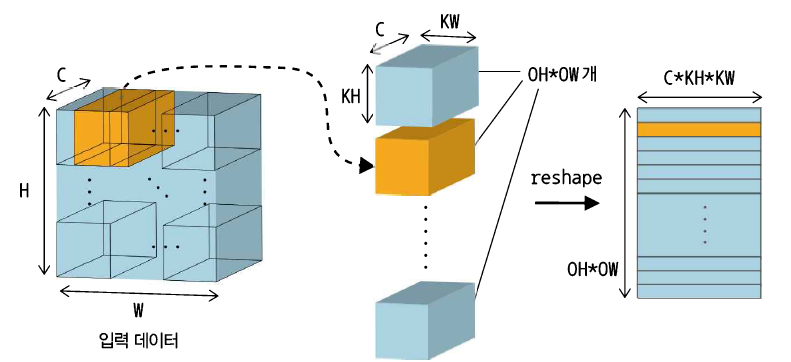

입력데이터 & 커널 전개 후 행렬곱
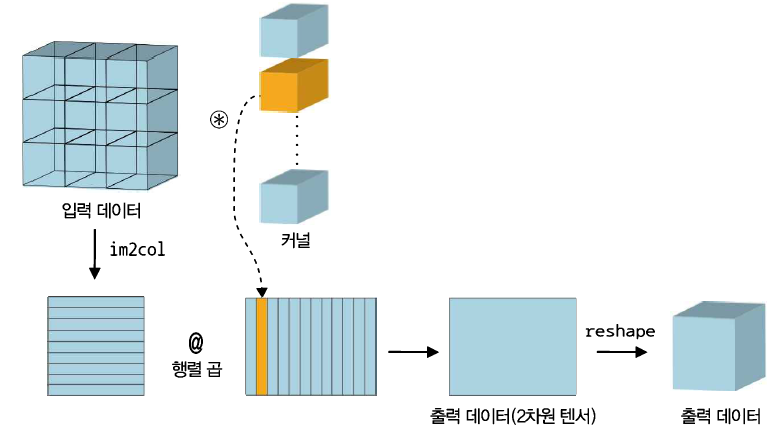

In [2]:
def pair(x):
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, tuple):
        # assert 문의 조건식을 참으로 만들경우 정상적으로 실행됨
        # 조건식이 거짓이 될 경우 assertion error 발생
        assert len(x) == 2        
        return x
    else:
        raise ValueError
        
print(pair(1))
print(pair((1,2)))

(1, 1)
(1, 2)


In [1]:
import numpy as np
import dezero.functions as F

x1 = np.random.rand(1, 3, 7, 7)
col1 = F.im2col(x1, kernel_size = 5, stride = 1, pad = 0, to_matrix = True)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix = True)
print(col2.shape)

(9, 75)
(90, 75)


im2col이미지

### conv2d function

In [ ]:
def conv2d_simple(x, W, b = None, stride = 1, pad = 0):
    x, W = as_variable(x), as_variable(W)
    
    Weight = W
    N, C, H, W = x.shape
    OC, C, KH, KW = Weight.shape 
    SH, SW = pair(stride)
    PH, PW = pair(pad)
    OH = get_conv_outsize(H, KH, SH, PH)
    OW = get_conv_outsize(W, KW, SW, PW)
    
    col = im2col(x, (KH, KW), stride, pad, to_matrix = True)  # flatten data
    Weight = Weight.reshape(OC, -1).transpose()               # flatten kernel
    t = linear(col, Weight, b)                                # flatten data에 대해 affine combination 계산
    y = t.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2)        # 첨부터 0 3 1 2순으로 reshape는 못함? 
    return y

### Conv2d layer

In [ ]:
class Conv2d(Layer):
    def __init__(self, out_channels, kernel_size, stride = 1,
                 pad = 0, nobias = False, dtype = np.float32, in_channels = None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        self.dtype = dtype
        
        self.W = Parameter(None, name = "W")
        if in_channels is not None:
            self._init_W()
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_channels, dtype = dtype), name = 'b')
        
    def _init_W(self, xp = np):
        C, OC = self.in_channels, self.out_channels
        KH, KW = pair(self.kernel_size)
        scale = np.sqrt(1 / (C * KH * KW))
        W_data = xp.random.randn(OC, C, KH, KW).astype(self.dtype) * scale
        self.W.data = W_data
        
    def forward(self, x):
        if self.W.data is None:
            self.in_channels = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)
            
        y = F.conv2d_simple(x, self.W, self.b, self.stride, self.pad)
        return y

### pooling function
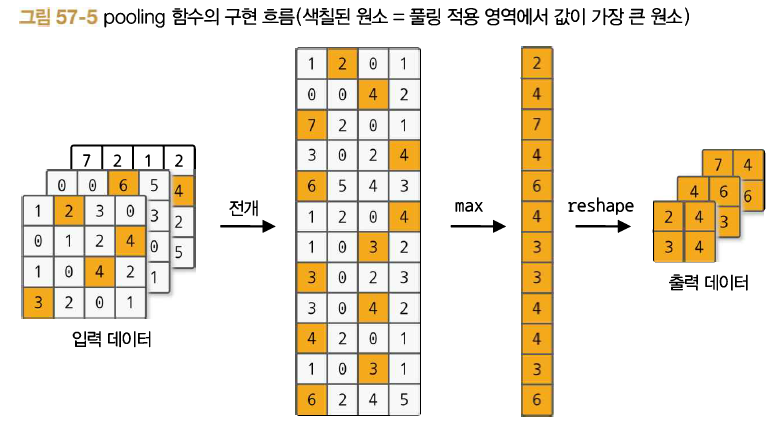

In [ ]:
def pooling_simple(x, kernel_size, stride = 1, pad = 0):
    x = as_variable(x)
    
    N, C, H, W = x.shape
    KH, KW = pair(kernel_size)
    PH, PW = pair(pad)S
    SH, SW = pair(stride)
    OH = get_conv_outsize(H, KH, SH, PH)
    OW = get_conv_outsize(W, KW, SW, PW)
    
    col = im2col(x, kernel_size, stride, pad, to_matrix = True)
    col = col.reshape(-1, KH * KW)
    y = col.max(axis = 1)
    y = y.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)
    return y